In [52]:
import skmob
from skmob.models import gravity
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
np.random.seed(0)

In [97]:
CSA_df = pd.read_csv('./data/CSA_df.csv')
CSA_df.head()

,Airport,lat,lon,state,state_code,city,CSA_Name
0,ATL,33.640833,-84.427222,Georgia,GA,Atlanta,"Atlanta--Athens-Clarke County--Sandy Springs, ..."
1,BOS,42.363611,-71.006111,Massachusetts,MA,Boston,"Boston-Worcester-Providence, MA-RI-NH-CT"
2,CLT,35.219167,-80.935833,North Carolina,NC,Charlotte,"Charlotte-Concord, NC-SC"
3,CHI,41.881528,-87.829028,Illinois,IL,Chicago,"Chicago-Naperville, IL-IN-WI"
4,DFW,32.894444,-97.029722,Texas,TX,Dallas/Fort Worth,"Dallas-Fort Worth, TX-OK"


In [98]:
us_CSA = gpd.read_file('./data/us_CSA.shp')
met = us_CSA[us_CSA['if_plot']==1]

In [99]:
met = met[['TotPop', 'CSA_Name', 'geometry']]
met = met.merge(right=CSA_df[['Airport', 'CSA_Name']], left_on='CSA_Name', right_on='CSA_Name')
met = met.rename(columns={'Airport': 'tile_ID', 'TotPop': 'population'}).sort_values(by='tile_ID')
tess = gpd.GeoDataFrame(met[['tile_ID', 'population']], geometry=met['geometry'], crs='EPSG:4326')
# totpop = tess['population'].values.reshape(-1, 1)
# scalar_pop = preprocessing.MinMaxScaler().fit(totpop)
# totpop = scalar_pop.transform(totpop)
# tess['population'] = totpop
tess.head()

,tile_ID,population,geometry
0,ATL,6584708,"POLYGON ((-85.16585 32.80850, -85.16563 32.808..."
1,BOS,8200935,"MULTIPOLYGON (((-71.88392 41.32650, -71.88213 ..."
3,CHI,9907569,"POLYGON ((-88.34208 41.11209, -88.34404 41.112..."
2,CLT,2656704,"POLYGON ((-81.42300 34.58677, -81.42269 34.587..."
5,DEN,3466374,"POLYGON ((-105.97241 38.89926, -105.97162 38.8..."


In [100]:
OD_df = pd.read_csv('./outputs/201904_OD_CSA.csv', index_col=0)


OD = OD_df

OD | Shape: (576, 1) , type: <class 'numpy.ndarray'>


In [101]:
ODa = OD.stack().reset_index().set_axis(['origin', 'destination', 'flow'], axis=1)
ODa = ODa.sort_values(by=['origin', 'destination']).reset_index(drop=True)
fdf = skmob.FlowDataFrame(ODa, origin='origin', destination='destination', flow='flow', tessellation=tess,
                          tile_id='tile_ID')

In [102]:
tot_outflows = fdf[fdf['origin']!=fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum()
tess = tess.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': 'tot_outflow'})
tess.head()

,tile_ID,population,geometry,tot_outflow
0,ATL,6584708,"POLYGON ((-85.16585 32.80850, -85.16563 32.808...",285674.0
1,BOS,8200935,"MULTIPOLYGON (((-71.88392 41.32650, -71.88213 ...",256955.0
2,CHI,9907569,"POLYGON ((-88.34208 41.11209, -88.34404 41.112...",412603.0
3,CLT,2656704,"POLYGON ((-81.42300 34.58677, -81.42269 34.587...",119230.0
4,DEN,3466374,"POLYGON ((-105.97241 38.89926, -105.97162 38.8...",279690.0


In [103]:
fdf_train = fdf[:]
fdf_train.shape

(576, 3)

In [104]:
count = [1 if fdf_train.loc[i, 'origin']==fdf_train.loc[i, 'destination'] else 0 for i in fdf_train.index]
sum(count)

24

In [105]:
count = [1 if fdf.loc[i, 'origin']==fdf.loc[i, 'destination'] else 0 for i in fdf.index]
sum(count)

24

In [106]:
ODb = ODa.pivot(index='origin', columns='destination', values='flow')
ODb.head()

destination,ATL,BOS,CHI,CLT,DEN,DFW,DTW,HNL,IAH,LAS,...,MSP,NYC,PHL,PHX,SAN,SEA,SFO,SLC,TPA,WAS
origin,,,,,,,,,,,,,,,,,,,,,
ATL,0.0,14164.0,22147.0,2612.0,12058.0,12241.0,9195.0,1427.0,7834.0,11396.0,...,6321.0,45042.0,11572.0,6964.0,4220.0,6052.0,7953.0,4235.0,10660.0,28980.0
BOS,14116.0,0.0,21849.0,7127.0,9950.0,8547.0,6668.0,1551.0,4643.0,7215.0,...,6875.0,22648.0,12129.0,6130.0,6138.0,6898.0,16984.0,3134.0,9766.0,31253.0
CHI,22189.0,22073.0,0.0,6918.0,22269.0,18006.0,6983.0,2298.0,10813.0,20312.0,...,16786.0,55294.0,13646.0,21368.0,11045.0,11580.0,18185.0,4533.0,15983.0,29763.0
CLT,2673.0,7240.0,6747.0,0.0,4937.0,5100.0,3464.0,294.0,3211.0,4747.0,...,3084.0,24802.0,5923.0,3155.0,1830.0,1746.0,3179.0,1375.0,2959.0,11643.0
DEN,11930.0,9963.0,22379.0,4792.0,0.0,12312.0,7846.0,1980.0,9661.0,15964.0,...,13724.0,22049.0,8293.0,19731.0,11205.0,12211.0,14066.0,8969.0,7126.0,19911.0


In [125]:
OD_ = np.array(ODb)  # shape: [num_cities, num_cities]
OD_ = OD_.reshape(-1, 1)
scalar_OD = preprocessing.MinMaxScaler().fit(OD_)

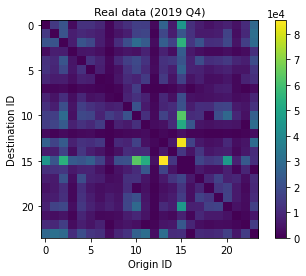

In [107]:
plt.imshow(ODb)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Real data (2019 Q4)', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))

# Gravity model

## Singly constrained

### Power law deterrence function

In [108]:
singly_fitted1 = gravity.Gravity(gravity_type='singly constrained')
print(singly_fitted1)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [109]:
singly_fitted1.fit(fdf_train, relevance_column='population')
print(singly_fitted1)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-0.05156525318824737], origin_exp=1.0, destination_exp=0.62388321292405, gravity_type="singly constrained")


In [110]:
fdf_fit1 = singly_fitted1.generate(tess, tile_id_column='tile_ID', tot_outflows_column='tot_outflow',
                                   relevance_column='population', out_format='flows')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32078.81it/s]
/opt/anaconda3/envs/bda_traff/lib/python3.8/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


In [111]:
fdf_fit1

,origin,destination,flow
0,ATL,BOS,15258.428638
1,ATL,CHI,17579.396899
2,ATL,CLT,8124.589592
3,ATL,DEN,8797.196874
4,ATL,DFW,14798.241382
...,...,...,...
547,WAS,SAN,10217.662950
548,WAS,SEA,12698.848390
549,WAS,SFO,19745.725401
550,WAS,SLC,8691.896439


In [112]:
OD_fit1 = pd.DataFrame(fdf_fit1[['origin', 'destination', 'flow']])
OD_rec1 = OD_fit1.pivot(index='origin', columns='destination', values='flow').fillna(0)
OD_rec1

destination,ATL,BOS,CHI,CLT,DEN,DFW,DTW,HNL,IAH,LAS,...,MSP,NYC,PHL,PHX,SAN,SEA,SFO,SLC,TPA,WAS
origin,,,,,,,,,,,,,,,,,,,,,
ATL,0.000000,15258.428638,17579.396899,8124.589592,8797.196874,14798.241382,11930.188630,3742.409133,13963.079625,6462.885505,...,9636.475049,29077.401490,14298.208178,10528.252796,8345.219291,10306.963752,16084.794955,7085.353505,8558.149960,17388.805020
BOS,12130.132850,0.000000,15713.315558,6979.000021,7868.252263,12978.447737,10867.679028,3394.453110,12209.579933,5807.566724,...,8696.314227,28726.352224,13621.570598,9418.315350,7487.799512,9334.348505,14489.276013,6370.231443,7385.849112,16111.931630
CHI,19966.765312,22449.973233,0.000000,11325.369324,13097.859845,21611.594913,18341.928086,5504.087273,20187.273919,9554.099804,...,14825.187313,42709.608955,20908.565696,15513.066554,12296.000584,15291.348000,23759.770009,10512.375668,11975.249586,25353.112041
CLT,5840.398531,6310.714082,7167.862778,0.000000,3568.765065,5960.935117,4905.258839,1524.415317,5618.319463,2625.211436,...,3925.156938,12064.407984,5955.642116,4270.844291,3388.452858,4195.671723,6538.317253,2878.505952,3454.340422,7277.051972
DEN,12774.562381,14372.232992,16745.507624,7209.059801,0.000000,14486.120945,11250.253851,3694.880084,13448.882528,6637.813756,...,9525.033948,27223.384844,13300.460292,10774.861860,8474.658569,10430.495691,16328.227649,7395.278280,7780.625917,16067.774965
DFW,10311.513475,11375.730973,13258.530237,5778.107937,6951.246561,0.000000,8905.949929,2887.016410,11308.225322,5065.985769,...,7401.710301,21583.296308,10563.657246,8311.733355,6546.881840,7998.026806,12553.700615,5553.345749,6276.391514,12781.741809
DTW,7600.883462,8709.592186,10288.640866,4347.480488,4936.025167,8143.005085,0.000000,2094.606602,7630.424952,3617.720570,...,5543.444180,16613.457212,8132.971446,5870.324092,4658.506214,5802.038201,9007.945186,3976.425059,4566.363817,9867.482345
HNL,2950.206552,3366.008639,3820.170341,1671.719513,2005.856161,3266.164880,2591.712739,0.000000,3075.134524,1518.562349,...,2151.186590,6357.709306,3101.370481,2447.858292,1966.680136,2453.139904,3832.150274,1650.576070,1813.640838,3737.506936
IAH,6974.081461,7670.978708,8877.276263,3903.652771,4625.836528,8105.651886,5981.880915,1948.358011,0.000000,3399.337240,...,4945.921219,14553.471646,7124.603543,5578.384699,4402.408786,5371.427456,8438.004545,3718.116795,4272.837623,8619.385566


In [126]:
pd.DataFrame(
    scalar_OD.transform(OD_rec1.to_numpy().reshape(-1, 1)).reshape(24, 24), \
    index = OD_df.index, columns=OD_df.columns
).to_csv('./res/gravity.csv')

In [128]:
OD = np.array(ODb)  # shape: [num_cities, num_cities]
OD = OD.reshape(-1, 1)
scalar_OD = preprocessing.MinMaxScaler().fit(OD)
OD = scalar_OD.transform(OD)
pd.DataFrame(
    OD.reshape(24, 24), \
    index = OD_df.index, columns=OD_df.columns
).to_csv('./res/gravity_labels.csv')

In [136]:
scalar_OD.data_max_

array([85322.])

In [129]:
OD_rec_long = OD_rec1.stack().reset_index().set_axis(['origin', 'destination', 'flow'], axis=1)
OD_rec_long = OD_rec_long[19:]
np.save('gravity.npy', OD_rec_long['flow'].to_numpy())

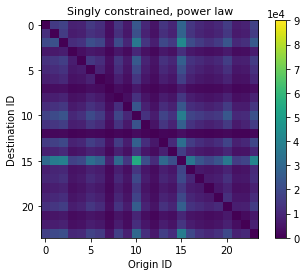

In [130]:
plt.imshow(OD_rec1, vmin=0, vmax=9e4)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Singly constrained, power law', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))

### Exponential deterrence function

In [90]:
singly_fitted2 = gravity.Gravity(gravity_type='singly constrained', deterrence_func_type='exponential')
print(singly_fitted2)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [91]:
singly_fitted2.fit(fdf, relevance_column='population')
print(singly_fitted2)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[0.00011578126651579154], origin_exp=1.0, destination_exp=0.5071238785939518, gravity_type="singly constrained")


In [92]:
fdf_fit2 = singly_fitted2.generate(tess, tile_id_column='tile_ID', tot_outflows_column='tot_outflow',
                                   relevance_column='population', out_format='flows')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 38956.38it/s]
/opt/anaconda3/envs/bda_traff/lib/python3.8/site-packages/skmob/models/gravity.py:378: RuntimeWarning: invalid value encountered in true_divide
  trip_probs_matrix = (trip_probs_matrix.T / np.sum(trip_probs_matrix, axis=1)).T


In [93]:
OD_fit2 = pd.DataFrame(fdf_fit2[['origin', 'destination', 'flow']])
OD_rec2 = OD_fit2.pivot(index='origin', columns='destination', values='flow').fillna(0)
OD_rec2.head()

destination,ATL,BOS,CHI,CLT,DEN,DFW,DTW,IAH,LAS,LAX,...,MSP,NYC,PHL,PHX,SAN,SEA,SFO,SLC,TPA,WAS
origin,,,,,,,,,,,,,,,,,,,,,
ATL,0.000000,0.188778,0.224026,0.102413,0.104317,0.188273,0.154988,0.178470,0.064654,0.250564,...,0.119813,0.340091,0.183890,0.119902,0.089088,0.106750,0.165420,0.075437,0.109753,0.222975
BOS,0.158714,0.000000,0.203590,0.089409,0.090213,0.154758,0.147938,0.144546,0.055514,0.212466,...,0.110365,0.363947,0.188499,0.100677,0.075132,0.096565,0.142789,0.065711,0.091023,0.219027
CHI,0.257882,0.278750,0.000000,0.139393,0.161355,0.271908,0.242069,0.249955,0.099259,0.380179,...,0.193944,0.498869,0.266702,0.179986,0.134420,0.169540,0.254968,0.117250,0.143484,0.321709
CLT,0.077218,0.080184,0.091303,0.000000,0.041454,0.073956,0.064262,0.069881,0.025594,0.098893,...,0.048615,0.144406,0.078119,0.047241,0.035118,0.042746,0.065521,0.029981,0.044018,0.094608
DEN,0.154944,0.159376,0.208199,0.081661,0.000000,0.187774,0.138461,0.170327,0.078895,0.301706,...,0.123149,0.285117,0.152597,0.141499,0.106451,0.130134,0.202408,0.092744,0.087831,0.184432


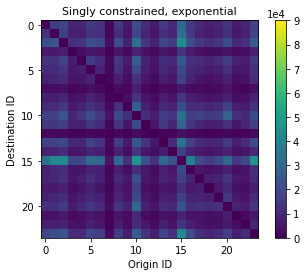

In [24]:
plt.imshow(OD_rec2, vmin=0, vmax=9e4)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Singly constrained, exponential', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))

## Globally constrained gravity model

### Power law deterrence function

In [25]:
globally_fitted1 = Gravity(gravity_type='globally constrained')
print(globally_fitted1)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="globally constrained")


In [26]:
globally_fitted1.fit(fdf, relevance_column='population')
print(globally_fitted1)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-0.05304299232341293], origin_exp=0.6250187103023493, destination_exp=0.6220923578385958, gravity_type="globally constrained")


In [27]:
fdf_fit3 = globally_fitted1.generate(tess, tile_id_column='tile_ID', tot_outflows_column='tot_outflow',
                                     relevance_column='population', out_format='flows')

100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24047.61it/s]
E:\Program_Files\Anaconda\envs\skmob\lib\site-packages\skmob\models\gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


In [28]:
OD_fit3 = pd.DataFrame(fdf_fit3[['origin', 'destination', 'flow']])
OD_rec3 = OD_fit3.pivot(index='origin', columns='destination', values='flow').fillna(0)
OD_rec3.head()

destination,ATL,BOS,CHI,CLT,DEN,DFW,DTW,HNL,IAH,LAS,...,MSP,NYC,PHL,PHX,SAN,SEA,SFO,SLC,TPA,WAS
origin,,,,,,,,,,,,,,,,,,,,,
ATL,0.000000,13431.018913,15479.268329,7181.010266,7752.572541,13032.276264,10515.934875,3298.684788,12299.096390,5696.806180,...,8493.666203,25555.569428,12595.390262,9269.230398,7350.141160,9070.209107,14137.431839,6244.872012,7555.927480,15314.143662
BOS,13439.648818,0.000000,17398.881968,7747.996039,8719.560509,14364.930047,12052.583823,3763.990601,13515.317321,6438.315673,...,9641.359671,31839.262103,15116.719113,10427.441718,8294.048032,10333.338586,16017.887239,7061.497047,8191.784799,17861.795094
CHI,15497.785766,17408.510204,0.000000,8804.626763,10171.759486,16762.974102,14260.649801,4273.823332,15656.627664,7419.939117,...,11526.012240,33065.957331,16222.753032,12032.333615,9540.830965,11857.206343,18398.955433,8164.200149,9300.671740,19664.723503
CLT,7161.961777,7722.481586,8770.779188,0.000000,4369.765499,7292.480054,6009.917912,1867.164007,6874.409135,3215.319115,...,4807.543747,14741.945768,7295.012640,5224.434533,4146.762833,5130.617053,7985.180862,3525.217411,4236.907222,8912.598153
DEN,7738.029446,8697.614911,10140.547357,4373.168583,0.000000,8780.483409,6817.953284,2242.086103,8149.532114,4032.588385,...,5779.898516,16446.502622,8052.261428,6537.454961,5142.723313,6323.554135,9887.863265,4494.390803,4718.005599,9723.370238


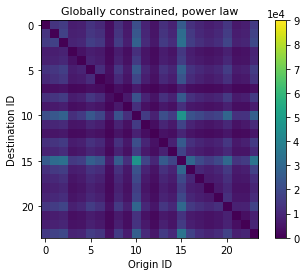

In [29]:
plt.imshow(OD_rec3, vmin=0, vmax=9e4)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Globally constrained, power law', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))

### Exponential deterrence function

In [30]:
globally_fitted2 = Gravity(gravity_type='globally constrained', deterrence_func_type='exponential')
print(globally_fitted2)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="globally constrained")


In [31]:
globally_fitted2.fit(fdf, relevance_column='population')
print(globally_fitted2)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[9.776271562665538e-05], origin_exp=0.6166892474685293, destination_exp=0.6136791775766628, gravity_type="globally constrained")


In [32]:
fdf_fit4 = globally_fitted2.generate(tess, tile_id_column='tile_ID', tot_outflows_column='tot_outflow',
                                     relevance_column='population', out_format='flows')

100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24018.92it/s]


In [33]:
OD_fit4 = pd.DataFrame(fdf_fit4[['origin', 'destination', 'flow']])
OD_rec4 = OD_fit4.pivot(index='origin', columns='destination', values='flow').fillna(0)
OD_rec4.head()

destination,ATL,BOS,CHI,CLT,DEN,DFW,DTW,HNL,IAH,LAS,...,MSP,NYC,PHL,PHX,SAN,SEA,SFO,SLC,TPA,WAS
origin,,,,,,,,,,,,,,,,,,,,,
ATL,0.000000,14142.003486,16756.457861,7907.354986,7982.514713,13988.834346,11423.574845,2097.181456,13222.920930,5483.043792,...,9004.702118,27087.436773,13608.639288,9107.635715,6983.663834,8252.177954,12905.582408,6135.849115,8335.245457,16633.143511
BOS,14151.350264,0.000000,18379.230384,8384.170973,8396.400982,14096.794070,13060.291204,2220.233823,13159.528033,5732.619681,...,9990.080764,34107.649368,16523.980886,9344.290697,7191.601549,9016.161140,13553.442068,6493.544408,8462.998609,19482.561798
CHI,16777.076977,18389.692176,0.000000,9598.946767,10795.146933,17853.099591,15575.739121,2836.471638,16443.639363,7368.239390,...,12654.067372,35027.199197,17429.862805,12008.945714,9248.418162,11411.626520,17401.026321,8331.793364,9779.923484,21210.289129
CLT,7885.780539,8355.773056,9560.992008,0.000000,4458.512231,7737.312311,6613.444978,1167.459176,7293.975231,3052.555806,...,5118.831584,16000.093619,8041.582106,5050.350443,3874.159050,4638.960354,7188.416805,3427.429435,4691.982526,9818.850910
DEN,7967.112291,8374.664948,10761.075788,4462.083803,0.000000,9535.665681,7095.708953,1699.110245,8684.490346,4431.645264,...,6296.243107,15946.090488,7942.388224,7156.185499,5545.219043,6664.171953,10454.898149,4990.674285,4717.945776,9681.090193


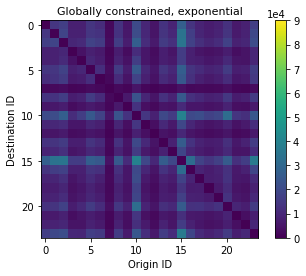

In [34]:
plt.imshow(OD_rec4, vmin=0, vmax=9e4)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Globally constrained, exponential', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))